# About this notebook

This notebook will contain my manual analysis of some abundance files/metadata I am using for testing purposes. 

The idea is to get a "reference" of sort of what I would normally do, and compare this to what the LLM decides to do.

In [74]:
# Load libraries

library(tidyverse)
library(edgeR)
library(limma)
library(tximport)
library(DESeq2)
library(janitor) # for cleaning up column names, though I'm not sure if this will be something that the LLM uses...
library(viridis)

Loading required package: viridisLite



In [83]:
# In addition to loading the sample metadata, as per below, I also need to load a bit of extra "data" which links the sample GEO accessions to the SRA IDs

link_meta <- read_tsv("~/work/notebooks//2_extract_data/results.txt") %>%
dplyr::rename(geo_accession = sample_ID)
link_meta

# Now that these are all linked, everything is more rigorous (that's generous, more like the analysis is valid now, before it was not)

files 

Rows: 12 Columns: 3
── Column specification ────────────────────────────────────────────────────────
Delimiter: "\t"
chr (3): sample_ID, experiment, SRA_ID

ℹ Use `spec()` to retrieve the full column specification for this data.
ℹ Specify the column types or set `show_col_types = FALSE` to quiet this message.


geo_accession,experiment,SRA_ID
<chr>,<chr>,<chr>
GSM8284513,SRX24625219,SRR29101291
GSM8284512,SRX24625218,SRR29101292
GSM8284511,SRX24625217,SRR29101293
GSM8284510,SRX24625216,SRR29101294
GSM8284509,SRX24625215,SRR29101295
GSM8284508,SRX24625214,SRR29101296
GSM8284507,SRX24625213,SRR29101297
GSM8284506,SRX24625212,SRR29101298
GSM8284505,SRX24625211,SRR29101299


[1] "/home/myuser/work/data/kallisto_output//SRR29101291/abundance.tsv"
 [2] "/home/myuser/work/data/kallisto_output//SRR29101292/abundance.tsv"
 [3] "/home/myuser/work/data/kallisto_output//SRR29101293/abundance.tsv"
 [4] "/home/myuser/work/data/kallisto_output//SRR29101294/abundance.tsv"
 [5] "/home/myuser/work/data/kallisto_output//SRR29101295/abundance.tsv"
 [6] "/home/myuser/work/data/kallisto_output//SRR29101296/abundance.tsv"
 [7] "/home/myuser/work/data/kallisto_output//SRR29101297/abundance.tsv"
 [8] "/home/myuser/work/data/kallisto_output//SRR29101298/abundance.tsv"
 [9] "/home/myuser/work/data/kallisto_output//SRR29101299/abundance.tsv"
[10] "/home/myuser/work/data/kallisto_output//SRR29101300/abundance.tsv"
[11] "/home/myuser/work/data/kallisto_output//SRR29101301/abundance.tsv"
[12] "/home/myuser/work/data/kallisto_output//SRR29101302/abundance.tsv"

In [84]:
# Load metadata

meta <- read_csv("~/work/notebooks//Testing/GSE268034/GSE268034_series_matrix_metadata.csv") %>%
    clean_names() %>%
    mutate(genotype_clean = str_remove_all(genotype_ch1, " ")) %>%
    left_join(link_meta, by = "geo_accession")
meta

Rows: 12 Columns: 44
── Column specification ────────────────────────────────────────────────────────
Delimiter: ","
chr (41): title, geo_accession, status, submission_date, last_update_date, t...
dbl  (3): channel_count, taxid_ch1, data_row_count

ℹ Use `spec()` to retrieve the full column specification for this data.
ℹ Specify the column types or set `show_col_types = FALSE` to quiet this message.


title,geo_accession,status,submission_date,last_update_date,type,channel_count,source_name_ch1,organism_ch1,characteristics_ch1,⋯,relation,relation_1,supplementary_file_1,cell_line_ch1,cell_type_ch1,genotype_ch1,treatment_ch1,genotype_clean,experiment,SRA_ID
<chr>,<chr>,<chr>,<chr>,<chr>,<chr>,<dbl>,<chr>,<chr>,<chr>,⋯,<chr>,<chr>,<chr>,<chr>,<chr>,<chr>,<chr>,<chr>,<chr>,<chr>
SUDHL4_LacZ_RGFP0_1,GSM8284502,Public on Aug 08 2024,May 21 2024,Aug 08 2024,SRA,1,SU-DHL-4,Homo sapiens,cell line: SU-DHL-4,⋯,BioSample: https://www.ncbi.nlm.nih.gov/biosample/SAMN41479047,SRA: https://www.ncbi.nlm.nih.gov/sra?term=SRX24625208,ftp://ftp.ncbi.nlm.nih.gov/geo/samples/GSM8284nnn/GSM8284502/suppl/GSM8284502_SUDHL4_LacZ_RGFP0_1.txt.gz,SU-DHL-4,diffuse large B-cell lymphoma cells,WT,DMSO,WT,SRX24625208,SRR29101302
SUDHL4_LacZ_RGFP0_2,GSM8284503,Public on Aug 08 2024,May 21 2024,Aug 08 2024,SRA,1,SU-DHL-4,Homo sapiens,cell line: SU-DHL-4,⋯,BioSample: https://www.ncbi.nlm.nih.gov/biosample/SAMN41479046,SRA: https://www.ncbi.nlm.nih.gov/sra?term=SRX24625209,ftp://ftp.ncbi.nlm.nih.gov/geo/samples/GSM8284nnn/GSM8284503/suppl/GSM8284503_SUDHL4_LacZ_RGFP0_2.txt.gz,SU-DHL-4,diffuse large B-cell lymphoma cells,WT,DMSO,WT,SRX24625209,SRR29101301
SUDHL4_LacZ_RGFP5_1,GSM8284504,Public on Aug 08 2024,May 21 2024,Aug 08 2024,SRA,1,SU-DHL-4,Homo sapiens,cell line: SU-DHL-4,⋯,BioSample: https://www.ncbi.nlm.nih.gov/biosample/SAMN41479045,SRA: https://www.ncbi.nlm.nih.gov/sra?term=SRX24625210,ftp://ftp.ncbi.nlm.nih.gov/geo/samples/GSM8284nnn/GSM8284504/suppl/GSM8284504_SUDHL4_LacZ_RGFP5_1.txt.gz,SU-DHL-4,diffuse large B-cell lymphoma cells,WT,RGFP966 (5 µM),WT,SRX24625210,SRR29101300
SUDHL4_LacZ_RGFP5_2,GSM8284505,Public on Aug 08 2024,May 21 2024,Aug 08 2024,SRA,1,SU-DHL-4,Homo sapiens,cell line: SU-DHL-4,⋯,BioSample: https://www.ncbi.nlm.nih.gov/biosample/SAMN41479044,SRA: https://www.ncbi.nlm.nih.gov/sra?term=SRX24625211,ftp://ftp.ncbi.nlm.nih.gov/geo/samples/GSM8284nnn/GSM8284505/suppl/GSM8284505_SUDHL4_LacZ_RGFP5_2.txt.gz,SU-DHL-4,diffuse large B-cell lymphoma cells,WT,RGFP966 (5 µM),WT,SRX24625211,SRR29101299
SUDHL4_GNASKO2_RGFP0_1,GSM8284506,Public on Aug 08 2024,May 21 2024,Aug 08 2024,SRA,1,SU-DHL-4,Homo sapiens,cell line: SU-DHL-4,⋯,BioSample: https://www.ncbi.nlm.nih.gov/biosample/SAMN41479043,SRA: https://www.ncbi.nlm.nih.gov/sra?term=SRX24625212,ftp://ftp.ncbi.nlm.nih.gov/geo/samples/GSM8284nnn/GSM8284506/suppl/GSM8284506_SUDHL4_GNASKO2_RGFP0_1.txt.gz,SU-DHL-4,diffuse large B-cell lymphoma cells,GNAS knockout,DMSO,GNASknockout,SRX24625212,SRR29101298
SUDHL4_GNASKO2_RGFP0_2,GSM8284507,Public on Aug 08 2024,May 21 2024,Aug 08 2024,SRA,1,SU-DHL-4,Homo sapiens,cell line: SU-DHL-4,⋯,BioSample: https://www.ncbi.nlm.nih.gov/biosample/SAMN41479042,SRA: https://www.ncbi.nlm.nih.gov/sra?term=SRX24625213,ftp://ftp.ncbi.nlm.nih.gov/geo/samples/GSM8284nnn/GSM8284507/suppl/GSM8284507_SUDHL4_GNASKO2_RGFP0_2.txt.gz,SU-DHL-4,diffuse large B-cell lymphoma cells,GNAS knockout,DMSO,GNASknockout,SRX24625213,SRR29101297
SUDHL4_GNASKO2_RGFP5_1,GSM8284508,Public on Aug 08 2024,May 21 2024,Aug 08 2024,SRA,1,SU-DHL-4,Homo sapiens,cell line: SU-DHL-4,⋯,BioSample: https://www.ncbi.nlm.nih.gov/biosample/SAMN41479041,SRA: https://www.ncbi.nlm.nih.gov/sra?term=SRX24625214,ftp://ftp.ncbi.nlm.nih.gov/geo/samples/GSM8284nnn/GSM8284508/suppl/GSM8284508_SUDHL4_GNASKO2_RGFP5_1.txt.gz,SU-DHL-4,diffuse large B-cell lymphoma cells,GNAS knockout,RGFP966 (5 µM),GNASknockout,SRX24625214,SRR29101296
SUDHL4_GNASKO2_RGFP5_2,GSM8284509,Public on Aug 08 2024,May 21 2024,Aug 08 2024,SRA,1,SU-DHL-4,Homo sapiens,cell line: SU-DHL-4,⋯,BioSample: https://www.ncbi.nlm.nih.gov/biosample/SAMN41479040,SRA: https://www.ncbi.nlm.nih.gov/sra?term=SRX24625215,ftp://ftp.ncbi.nlm.nih.gov/geo/samples/GSM8284nnn/GSM8284509/suppl/GSM8284509_SUDHL4_GNASKO2_RGFP5_2.txt.gz,SU-DHL-4,diffuse large B-cell lymphoma cells,GNAS knockout,RGFP966 (5 µM),GNASknockout,SRX24625215,SRR29101295
SUDHL4_GNASKO3_RGFP0_1,GSM82845

In [87]:
files <- list.files(path = "~/work/data/kallisto_output/",
                    pattern = "abundance.tsv",
                    recursive = TRUE,
                    full.names = TRUE)

file_data <- data.frame(path = files,
                        SRA_ID = basename(dirname(files)))

left_join(meta, file_data, by = "SRA_ID")

title,geo_accession,status,submission_date,last_update_date,type,channel_count,source_name_ch1,organism_ch1,characteristics_ch1,⋯,relation_1,supplementary_file_1,cell_line_ch1,cell_type_ch1,genotype_ch1,treatment_ch1,genotype_clean,experiment,SRA_ID,path
<chr>,<chr>,<chr>,<chr>,<chr>,<chr>,<dbl>,<chr>,<chr>,<chr>,⋯,<chr>,<chr>,<chr>,<chr>,<chr>,<chr>,<chr>,<chr>,<chr>,<chr>
SUDHL4_LacZ_RGFP0_1,GSM8284502,Public on Aug 08 2024,May 21 2024,Aug 08 2024,SRA,1,SU-DHL-4,Homo sapiens,cell line: SU-DHL-4,⋯,SRA: https://www.ncbi.nlm.nih.gov/sra?term=SRX24625208,ftp://ftp.ncbi.nlm.nih.gov/geo/samples/GSM8284nnn/GSM8284502/suppl/GSM8284502_SUDHL4_LacZ_RGFP0_1.txt.gz,SU-DHL-4,diffuse large B-cell lymphoma cells,WT,DMSO,WT,SRX24625208,SRR29101302,/home/myuser/work/data/kallisto_output//SRR29101302/abundance.tsv
SUDHL4_LacZ_RGFP0_2,GSM8284503,Public on Aug 08 2024,May 21 2024,Aug 08 2024,SRA,1,SU-DHL-4,Homo sapiens,cell line: SU-DHL-4,⋯,SRA: https://www.ncbi.nlm.nih.gov/sra?term=SRX24625209,ftp://ftp.ncbi.nlm.nih.gov/geo/samples/GSM8284nnn/GSM8284503/suppl/GSM8284503_SUDHL4_LacZ_RGFP0_2.txt.gz,SU-DHL-4,diffuse large B-cell lymphoma cells,WT,DMSO,WT,SRX24625209,SRR29101301,/home/myuser/work/data/kallisto_output//SRR29101301/abundance.tsv
SUDHL4_LacZ_RGFP5_1,GSM8284504,Public on Aug 08 2024,May 21 2024,Aug 08 2024,SRA,1,SU-DHL-4,Homo sapiens,cell line: SU-DHL-4,⋯,SRA: https://www.ncbi.nlm.nih.gov/sra?term=SRX24625210,ftp://ftp.ncbi.nlm.nih.gov/geo/samples/GSM8284nnn/GSM8284504/suppl/GSM8284504_SUDHL4_LacZ_RGFP5_1.txt.gz,SU-DHL-4,diffuse large B-cell lymphoma cells,WT,RGFP966 (5 µM),WT,SRX24625210,SRR29101300,/home/myuser/work/data/kallisto_output//SRR29101300/abundance.tsv
SUDHL4_LacZ_RGFP5_2,GSM8284505,Public on Aug 08 2024,May 21 2024,Aug 08 2024,SRA,1,SU-DHL-4,Homo sapiens,cell line: SU-DHL-4,⋯,SRA: https://www.ncbi.nlm.nih.gov/sra?term=SRX24625211,ftp://ftp.ncbi.nlm.nih.gov/geo/samples/GSM8284nnn/GSM8284505/suppl/GSM8284505_SUDHL4_LacZ_RGFP5_2.txt.gz,SU-DHL-4,diffuse large B-cell lymphoma cells,WT,RGFP966 (5 µM),WT,SRX24625211,SRR29101299,/home/myuser/work/data/kallisto_output//SRR29101299/abundance.tsv
SUDHL4_GNASKO2_RGFP0_1,GSM8284506,Public on Aug 08 2024,May 21 2024,Aug 08 2024,SRA,1,SU-DHL-4,Homo sapiens,cell line: SU-DHL-4,⋯,SRA: https://www.ncbi.nlm.nih.gov/sra?term=SRX24625212,ftp://ftp.ncbi.nlm.nih.gov/geo/samples/GSM8284nnn/GSM8284506/suppl/GSM8284506_SUDHL4_GNASKO2_RGFP0_1.txt.gz,SU-DHL-4,diffuse large B-cell lymphoma cells,GNAS knockout,DMSO,GNASknockout,SRX24625212,SRR29101298,/home/myuser/work/data/kallisto_output//SRR29101298/abundance.tsv
SUDHL4_GNASKO2_RGFP0_2,GSM8284507,Public on Aug 08 2024,May 21 2024,Aug 08 2024,SRA,1,SU-DHL-4,Homo sapiens,cell line: SU-DHL-4,⋯,SRA: https://www.ncbi.nlm.nih.gov/sra?term=SRX24625213,ftp://ftp.ncbi.nlm.nih.gov/geo/samples/GSM8284nnn/GSM8284507/suppl/GSM8284507_SUDHL4_GNASKO2_RGFP0_2.txt.gz,SU-DHL-4,diffuse large B-cell lymphoma cells,GNAS knockout,DMSO,GNASknockout,SRX24625213,SRR29101297,/home/myuser/work/data/kallisto_output//SRR29101297/abundance.tsv
SUDHL4_GNASKO2_RGFP5_1,GSM8284508,Public on Aug 08 2024,May 21 2024,Aug 08 2024,SRA,1,SU-DHL-4,Homo sapiens,cell line: SU-DHL-4,⋯,SRA: https://www.ncbi.nlm.nih.gov/sra?term=SRX24625214,ftp://ftp.ncbi.nlm.nih.gov/geo/samples/GSM8284nnn/GSM8284508/suppl/GSM8284508_SUDHL4_GNASKO2_RGFP5_1.txt.gz,SU-DHL-4,diffuse large B-cell lymphoma cells,GNAS knockout,RGFP966 (5 µM),GNASknockout,SRX24625214,SRR29101296,/home/myuser/work/data/kallisto_output//SRR29101296/abundance.tsv
SUDHL4_GNASKO2_RGFP5_2,GSM8284509,Public on Aug 08 2024,May 21 2024,Aug 08 2024,SRA,1,SU-DHL-4,Homo sapiens,cell line: SU-DHL-4,⋯,SRA: https://www.ncbi.nlm.nih.gov/sra?term=SRX24625215,ftp://ftp.ncbi.nlm.nih.gov/geo/samples/GSM8284nnn/GSM8284509/suppl/GSM8284509_SUDHL4_GNASKO2_RGFP5_2.txt.gz,SU-DHL-4,diffuse large B-cell lymphoma cells,GNAS knockout,RGFP966 (5 µM),GNASknockout,SRX24625215,SRR29101295,/home/myuser/work/data/kallisto_output//SRR29101295/abundance.tsv
SUDHL4_GNAS

In [18]:
# List the abundance files. The tsv files should work...

files <- list.files(path = "~/work/data/kallisto_output/",
                    pattern = "abundance.tsv",
                    recursive = TRUE,
                    full.names = TRUE)

file_data <- data.frame(path = files,
                        SRA_ID = basename(dirname(files)))

tx2gene <- read_tsv("~/work/data/kallisto_indices//human/t2g.txt",
                   col_names = FALSE) %>%
dplyr::select(1, 3) %>%
drop_na()
kallisto <- tximport(files = files,
         type = "kallisto",
         tx2gene = tx2gene,
         ignoreAfterBar = TRUE,
                    countsFromAbundance = "lengthScaledTPM")

Rows: 227665 Columns: 8
── Column specification ────────────────────────────────────────────────────────
Delimiter: "\t"
chr (6): X1, X2, X3, X4, X5, X8
dbl (2): X6, X7

ℹ Use `spec()` to retrieve the full column specification for this data.
ℹ Specify the column types or set `show_col_types = FALSE` to quiet this message.
Note: importing `abundance.h5` is typically faster than `abundance.tsv`

reading in files with read_tsv

1 
2 
3 
4 
5 
6 
7 
8 
9 
10 
11 
12 


transcripts missing from tx2gene: 24683

summarizing abundance

summarizing counts

summarizing length



In [53]:
DGE <- DGEList(counts = kallisto$counts,
              samples = meta)

In [54]:
str(DGE)

Formal class 'DGEList' [package "edgeR"] with 1 slot
  ..@ .Data:List of 2
  .. ..$ : num [1:25668, 1:12] 0 0 0 0 0 0 0 0 0 0 ...
  .. .. ..- attr(*, "dimnames")=List of 2
  .. .. .. ..$ : chr [1:25668] "A1BG" "A1BG-AS1" "A1CF" "A2M" ...
  .. .. .. ..$ : chr [1:12] "Sample1" "Sample2" "Sample3" "Sample4" ...
  .. ..$ :'data.frame':	12 obs. of  48 variables:
  .. .. ..$ group                  : Factor w/ 1 level "1": 1 1 1 1 1 1 1 1 1 1 ...
  .. .. ..$ lib.size               : num [1:12] 26356 25952 28192 26604 25214 ...
  .. .. ..$ norm.factors           : num [1:12] 1 1 1 1 1 1 1 1 1 1 ...
  .. .. ..$ title                  : chr [1:12] "SUDHL4_LacZ_RGFP0_1" "SUDHL4_LacZ_RGFP0_2" "SUDHL4_LacZ_RGFP5_1" "SUDHL4_LacZ_RGFP5_2" ...
  .. .. ..$ geo_accession          : chr [1:12] "GSM8284502" "GSM8284503" "GSM8284504" "GSM8284505" ...
  .. .. ..$ status                 : chr [1:12] "Public on Aug 08 2024" "Public on Aug 08 2024" "Public on Aug 08 2024" "Public on Aug 08 2024" ...
  .. .. ..

I'm immediately noticing I will need to integrate the results.txt (or whatever) output from when I extracted the FASTQ files, since this is the way I will be using to link GEO accessions to the SRA IDs.

Just for testing purposes (to make sure all the command I intend can run on the container), I won't worry about this yet. However, it is something I will need to consider when building the framework.

For whatever reason this was VERY quick (quicker than when I run this on my laptop...)

In [56]:
keep.exprs <- filterByExpr(DGE,
                          group = DGE$samples$genotype_clean)

In [57]:
DGE.filtered <- DGE[keep.exprs, keep.lib.sizes = FALSE]

In [58]:
dim(DGE)
dim(DGE.filtered)

[1] 25668    12

[1] 621  12

Ah. I imagine since I only am using a subset of the FASTQ files, that is why everything has been extraordinarily quick. 

In [80]:
# Produce a plot displaying the results of filtering

L <- mean(DGE$samples$lib.size) * 1e-6
M <- median(DGE$samples$lib.size) * 1e-6

cpm <- cpm(DGE)
lcpm <- cpm(DGE, log = T)

lcpm.cutoff <- log2(10/M + 2/L)
nsamples <- ncol(DGE) #define number of samples

col <- viridis(n = nsamples, direction = -1) #defining a colour palette - different to what was had originally.

png("./Filtering.png")

par(mfrow=c(1,2)) # for seeing plots side by side

lcpm <- cpm(DGE, log = T)
plot(density(lcpm[,1]), col=col[1], lwd=2, ylim=c(0,0.5), las=2, main="", xlab="")
title(main="A. Unfiltered data", xlab="Log-cpm") # creating titles
abline(v=lcpm.cutoff, lty=3) # add the vertical line to represent the lcpm cutoff
for (i in 2:nsamples){ #for each sample...
  den <- density(lcpm[,i]) #compute the Kernel density estimate?
  lines(den$x, den$y, col=col[i], lwd=2)
}
lcpm <- cpm(DGE.filtered, log=TRUE)
plot(density(lcpm[,1]), col=col[1], lwd=2, ylim=c(0,0.5), las=2, main="", xlab="")
title(main="B. Filtered data", xlab="Log-cpm")
abline(v=lcpm.cutoff, lty=3)
for (i in 2:nsamples){
  den <- density(lcpm[,i])
  lines(den$x, den$y, col=col[i], lwd=2)
}

dev.off()

# There is no way the LLM is going to produce code that looks like this. I am still curious if the API is able to interpret such plots.


png 
  2

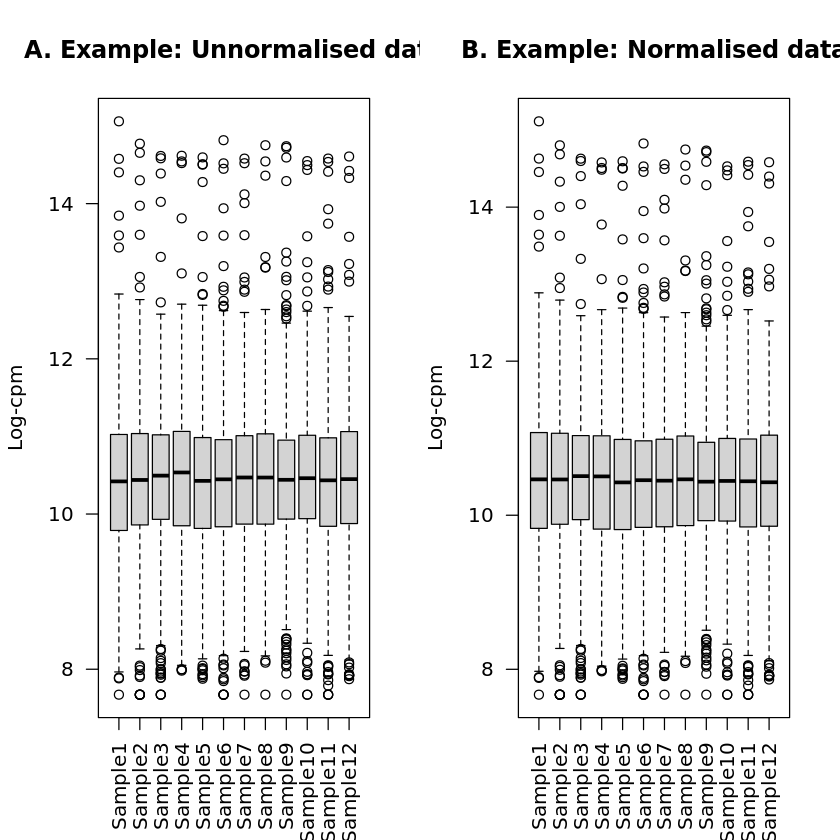

In [88]:
DGE.final <- calcNormFactors(DGE.filtered)

par(mfrow=c(1,2))
lcpm <- cpm(DGE.filtered, log=TRUE)
boxplot(lcpm, las=2, main="")
title(main="A. Example: Unnormalised data",ylab="Log-cpm")
lcpm <- cpm(DGE.final, log=TRUE)
boxplot(lcpm, las=2, main="")
title(main="B. Example: Normalised data",ylab="Log-cpm")


In [63]:
design <- model.matrix(data = DGE.final$samples,
                       ~0 + genotype_clean)
colnames(design) <- str_remove_all(colnames(design),
                                   "genotype_clean")
contrast.matrix <- makeContrasts(
    KO = "GNASknockout - WT",
    levels = colnames(design))

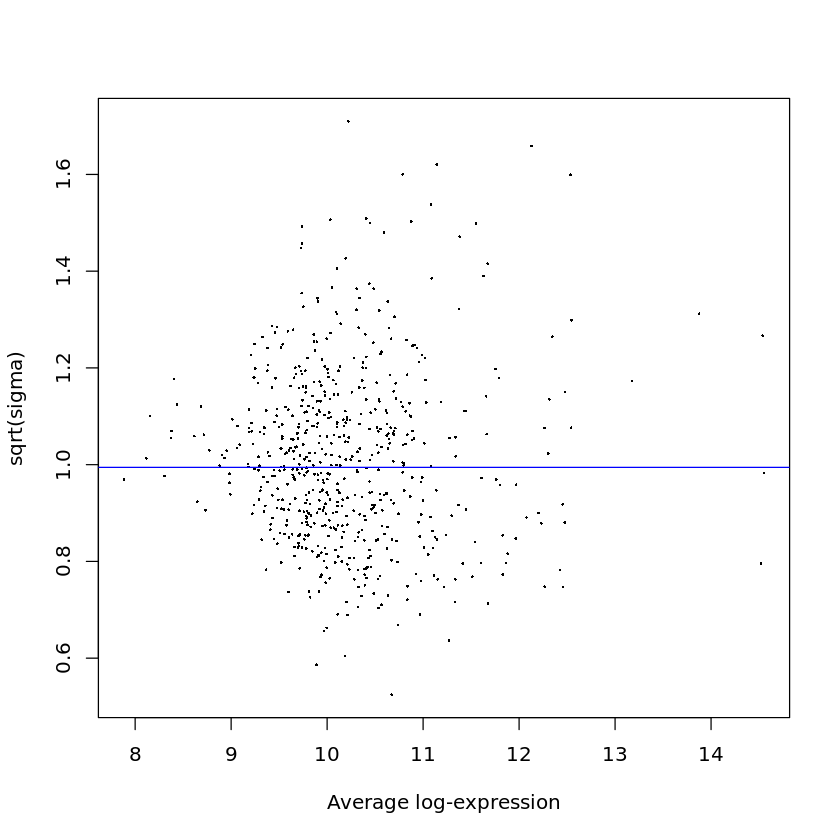

In [67]:
v <- voom(DGE.final,
          design)
vfit <- lmFit(v,
              design)
vfit <- contrasts.fit(vfit,
                      contrast.matrix)
efit <- eBayes(vfit)

plotSA(efit)

Well, given the lack of genes, I'm not too surprised that this is what the plot looks like. Anyway, it seems the rough pipeline is at least functional for now, so let's do the DEG analysis and roughly make sure it works

Side note - I chose a contrast that I quickly thought would probably be worth doing (i.e. a glance tells me it would probably be useful?), but I didn't really check in depth to be honest.

In [71]:
contrasts <- colnames(contrast.matrix)

LFC.summary <- sapply(contrasts, function(x){
    lfc.list <- list()
    top <- topTable(efit,
                    coef = x,
                    number = Inf) %>%
    list()
    lfc.list <- append(lfc.list, top)
    })

LFC.summary[[1]] %>%
arrange(adj.P.Val)

    

,logFC,AveExpr,t,P.Value,adj.P.Val,B
,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>
RPL41,0.5540266,11.674890,2.972225,0.008019883,0.6365989,-4.199617
GNB1,-1.0707043,10.593562,-3.764368,0.001373350,0.6365989,-4.221713
TTN,1.4961492,12.128468,2.821683,0.011126588,0.6365989,-4.245745
DGKD,-1.0046919,10.625564,-3.033836,0.007006884,0.6365989,-4.317825
PAK2,-0.9756117,10.637952,-3.022942,0.007176475,0.6365989,-4.318063
HNRNPUL1,-1.1018379,10.133262,-3.026324,0.007123415,0.6365989,-4.421977
XRN1,-1.4622253,9.757983,-3.254400,0.004303672,0.6365989,-4.474913
AFF4,-1.6437223,9.483334,-2.929447,0.008805207,0.6365989,-4.522281
CEP192,-1.4164159,9.480559,-2.852505,0.010408451,0.6365989,-4.523883


Ok, this technically works - I am curious what the LLM will do.

# Further testing

I want to get an idea of what the "cleaned" DGE object looks like from my test case, and make sure it is compatible with ~makeContrasts~


In [91]:
DGE <- readRDS("../TheLLMPlayground/LLMInputs/DGE.RDS")

In [92]:
DGE$samples # Looks like what I'd expect

,group,lib.size,norm.factors,title,geo_accession,status,submission_date,last_update_date,type,channel_count,⋯,cell_line_ch1,cell_type_ch1,genotype_ch1,treatment_ch1,genotype_clean,treatment_clean,genotype_treatment,experiment,SRA_ID,path
,<fct>,<dbl>,<dbl>,<chr>,<chr>,<chr>,<chr>,<chr>,<chr>,<dbl>,⋯,<chr>,<chr>,<chr>,<chr>,<chr>,<chr>,<chr>,<chr>,<chr>,<chr>
Sample1,1,8689.609,0.9635031,SUDHL4_LacZ_RGFP0_1,GSM8284502,Public on Aug 08 2024,May 21 2024,Aug 08 2024,SRA,1,⋯,SU-DHL-4,diffuse large B-cell lymphoma cells,WT,DMSO,WT,DMSO,WT_DMSO,SRX24625208,SRR29101302,/home/myuser/work/data/kallisto_output//SRR29101302/abundance.tsv
Sample2,1,8631.964,0.9791838,SUDHL4_LacZ_RGFP0_2,GSM8284503,Public on Aug 08 2024,May 21 2024,Aug 08 2024,SRA,1,⋯,SU-DHL-4,diffuse large B-cell lymphoma cells,WT,DMSO,WT,DMSO,WT_DMSO,SRX24625209,SRR29101301,/home/myuser/work/data/kallisto_output//SRR29101301/abundance.tsv
Sample3,1,9067.886,0.9896013,SUDHL4_LacZ_RGFP5_1,GSM8284504,Public on Aug 08 2024,May 21 2024,Aug 08 2024,SRA,1,⋯,SU-DHL-4,diffuse large B-cell lymphoma cells,WT,RGFP966 (5 µM),WT,RGFP9665M,WT_RGFP9665M,SRX24625210,SRR29101300,/home/myuser/work/data/kallisto_output//SRR29101300/abundance.tsv
Sample4,1,8709.116,1.0257883,SUDHL4_LacZ_RGFP5_2,GSM8284505,Public on Aug 08 2024,May 21 2024,Aug 08 2024,SRA,1,⋯,SU-DHL-4,diffuse large B-cell lymphoma cells,WT,RGFP966 (5 µM),WT,RGFP9665M,WT_RGFP9665M,SRX24625211,SRR29101299,/home/myuser/work/data/kallisto_output//SRR29101299/abundance.tsv
Sample5,1,8503.911,1.0005531,SUDHL4_GNASKO2_RGFP0_1,GSM8284506,Public on Aug 08 2024,May 21 2024,Aug 08 2024,SRA,1,⋯,SU-DHL-4,diffuse large B-cell lymphoma cells,GNAS knockout,DMSO,GNASknockout,DMSO,GNASknockout_DMSO,SRX24625212,SRR29101298,/home/myuser/work/data/kallisto_output//SRR29101298/abundance.tsv
Sample6,1,9099.935,0.9937178,SUDHL4_GNASKO2_RGFP0_2,GSM8284507,Public on Aug 08 2024,May 21 2024,Aug 08 2024,SRA,1,⋯,SU-DHL-4,diffuse large B-cell lymphoma cells,GNAS knockout,DMSO,GNASknockout,DMSO,GNASknockout_DMSO,SRX24625213,SRR29101297,/home/myuser/work/data/kallisto_output//SRR29101297/abundance.tsv
Sample7,1,9482.690,1.0174526,SUDHL4_GNASKO2_RGFP5_1,GSM8284508,Public on Aug 08 2024,May 21 2024,Aug 08 2024,SRA,1,⋯,SU-DHL-4,diffuse large B-cell lymphoma cells,GNAS knockout,RGFP966 (5 µM),GNASknockout,RGFP9665M,GNASknockout_RGFP9665M,SRX24625214,SRR29101296,/home/myuser/work/data/kallisto_output//SRR29101296/abundance.tsv
Sample8,1,10118.793,1.0033437,SUDHL4_GNASKO2_RGFP5_2,GSM8284509,Public on Aug 08 2024,May 21 2024,Aug 08 2024,SRA,1,⋯,SU-DHL-4,diffuse large B-cell lymphoma cells,GNAS knockout,RGFP966 (5 µM),GNASknockout,RGFP9665M,GNASknockout_RGFP9665M,SRX24625215,SRR29101295,/home/myuser/work/data/kallisto_output//SRR29101295/abundance.tsv
Sample9,1,10998.314,1.0039312,SUDHL4_GNASKO3_RGFP0_1,GSM8284510,Public on Aug 08 2024,May 21 2024,Aug 08 2024,SRA,1,⋯,SU-DHL-4,diffuse large B-cell lymphoma cells,GNAS knockout,DMSO,GNASknockout,DMSO,GNASknockout_DMSO,SRX24625216,SRR29101294,/home/myuser/work/data/kallisto_output//SRR29101294/abundance.tsv


In [97]:
design <- model.matrix(data = DGE$samples,
                       ~0 + genotype_treatment)
colnames(design) <- str_remove_all(colnames(design), "genotype_treatment")

In [99]:
design

,GNASknockout_DMSO,GNASknockout_RGFP9665M,WT_DMSO,WT_RGFP9665M
Sample1,0,0,1,0
Sample2,0,0,1,0
Sample3,0,0,0,1
Sample4,0,0,0,1
Sample5,1,0,0,0
Sample6,1,0,0,0
Sample7,0,1,0,0
Sample8,0,1,0,0
Sample9,1,0,0,0
Sample10,1,0,0,0


In [104]:
contrast.matrix <- makeContrasts(GNASKO_WT = "(GNASknockout_DMSO + GNASknockout_RGFP9665M) - (WT_DMSO + WT_RGFP9665M)",
                                 DMSO = "GNASknockout_RGFP9665M - GNASknockout_DMSO",
                                levels = colnames(design))
    

In [105]:
contrast.matrix

,GNASKO_WT,DMSO
GNASknockout_DMSO,1,-1
GNASknockout_RGFP9665M,1,1
WT_DMSO,-1,0
WT_RGFP9665M,-1,0
